# Import Libraries & Intial x,y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import datetime as dt
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import time as t
import os
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# Read The Data
data = pd.read_csv('hotel-regression-dataset.csv')

# set X & Y
y = data.iloc[:, 16]
x = data.iloc[:, 0:16]

# Split Train_Test & Sentiment Analysis

In [2]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [3]:
from textblob import TextBlob

# Define a function to analyze the sentiment of a sentence
def get_sentiment(sentence):
    blob = TextBlob(sentence)
    return blob.sentiment.polarity

# Apply the sentiment analysis function to each row in the positive and negative columns
def apply_sentiment(data):
    data['positive_sentiment'] = data['Positive_Review'].apply(get_sentiment)
    data['negative_sentiment'] = data['Negative_Review'].apply(get_sentiment)
    return data

# Preprocessing

## Missing Vlaues && Endcoding

In [4]:
def split_Review_Date(data):
    # split Review_Date
    # df = pd.DataFrame()
    data['Review_Date'] = pd.to_datetime(data['Review_Date'])
    data['Year'] = data['Review_Date'].dt.year
    data['Month'] = data['Review_Date'].dt.month
    data['Day'] = data['Review_Date'].dt.day
    data = data.drop(["Review_Date"], axis=1)
    return data

def split_Tags_days_since(data):
    # split Tags
    Trip = []
    Members = []
    Room_Kind = []
    Nights = []
    the_way_of_submission = []
    Tags = list(data['Tags'])
    tag = []
    days = list(data['days_since_review'])
    days_final = []
    for i in range(len(Tags)):
        Tags[i] = Tags[i].replace("[", "")
        Tags[i] = Tags[i].replace("]", "")
        Tags[i] = Tags[i].replace("'", "")
        tag.append(Tags[i].split(","))
        # clean days_since review
        days[i] = str(days[i]).replace("days", "")
        days[i] = str(days[i]).replace("day", "")
        days_final.append(int(days[i]))
    for j in tag:
        trip = False
        mem = False
        room = False
        night = False
        submission = False
        for k in j:
            if k.__contains__("trip"):
                Trip.append(k)
                trip = True
            elif k.__contains__('room') or k.__contains__('Room'):
                Room_Kind.append(k)
                room = True
            elif (k.__contains__('Stayed')):
                result = ''.join(char for char in k if char.isdigit())
                Nights.append(int(result))
                night = True
            elif k.__contains__('Submitted'):
                the_way_of_submission.append(k)
                submission = True
            elif k.__contains__('Couple') or k.__contains__('Group') or k.__contains__('children') or k.__contains__(
                    'traveler'):
                Members.append(k)
                mem = True
        if not trip:
            Trip.append('no trip')
        if not room:
            Room_Kind.append('no room')
        if not night:
            Nights.append(0)
        if not submission:
            the_way_of_submission.append('not Submitted')
        if not mem:
            Members.append('no one')
    data['Trip'] = Trip
    data['Members'] = Members
    data['Room'] = Room_Kind
    data['Nights'] = Nights
    data['Submission'] = the_way_of_submission
    data = data.drop(['Tags'], axis=1)
    data['days_since_review'] = days_final
    return data

def data_cleaning_X_Train(X_train):

    X_train['Positive_Review'] = X_train['Positive_Review'].replace('No Positive', np.nan)
    X_train['Negative_Review'] = X_train['Negative_Review'].replace('No Negative', np.nan)
    
    # drop columns with all nan values
    X_train = X_train.dropna(axis=1, how="all")
    

    mean_list = []
    mean_list.append(X_train['Average_Score'].mean())
    mean_list.append(X_train['Total_Number_of_Reviews'].mean())  # ask
    mean_list.append(X_train['lat'].mean())
    mean_list.append(X_train['lng'].mean())

   
    # data with filling missing values (X_train)
    X_train = X_train.fillna({'Hotel_Address': 'no address', 'Additional_Number_of_Scoring': 0.0,
                              'Review_Date': "00/00/0000", 'Average_Score': mean_list[0], 'Hotel_Name': 'no name',
                              'Reviewer_Nationality': 'no info', 'Negative_Review': 'positive',
                              'Review_Total_Negative_Word_Counts': 0.0, 'Total_Number_of_Reviews': mean_list[1],
                              'Positive_Review': 'negative', 'Review_Total_Positive_Word_Counts': 0.0,
                              'Total_Number_of_Reviews_Reviewer_Has_Given': 0.0,
                              'Tags': "[' no trip ', ' no ', ' no Room ', ' 0 nights ', 'not Submitted']",
                              'days_since_review': '0 day', 'lat': mean_list[2], 'lng': mean_list[3]}) #, 'Reviewer_Score': 0.0})


    # split Review_Date
    X_train = split_Review_Date(X_train) # For X_train
    
    # split Tags
    X_train = split_Tags_days_since(X_train) # For X_train
    
    return X_train,mean_list

def data_cleaning_X_Test(X_test,mean_list):

    X_test['Positive_Review'] = X_test['Positive_Review'].replace('No Positive', np.nan)
    X_test['Negative_Review'] = X_test['Negative_Review'].replace('No Negative', np.nan)
    

    # drop columns with all nan values
    X_test = X_test.dropna(axis=1, how="all")
    
    
    # data with filling missing values (X_test)
    X_test = X_test.fillna({'Hotel_Address': 'no address', 'Additional_Number_of_Scoring': 0.0,
                            'Review_Date': "00/00/0000", 'Average_Score': mean_list[0], 'Hotel_Name': 'no name',
                            'Reviewer_Nationality': 'no info', 'Negative_Review': 'positive',
                            'Review_Total_Negative_Word_Counts': 0.0, 'Total_Number_of_Reviews': mean_list[1],
                            'Positive_Review': 'negative', 'Review_Total_Positive_Word_Counts': 0.0,
                            'Total_Number_of_Reviews_Reviewer_Has_Given': 0.0,
                            'Tags': "[' no trip ', ' no ', ' no Room ', ' 0 nights ', 'not Submitted']",
                            'days_since_review': '0 day', 'lat': mean_list[2], 'lng': mean_list[3]}) #, 'Reviewer_Score': 0.0})


    # split Review_Date
    X_test = split_Review_Date(X_test) # For X_train
    
    # split Tags
    X_test = split_Tags_days_since(X_test) # For X_train
    
    return X_test

# Handle The Missing Values In The Reviewer_Score With Tec: Predictive imputation

def data_cleaning_Y_Train(y_train):
    
    mean = y_train.mean()
    y_train = y_train.fillna({'Reviewer_Score': mean})
    
    return y_train , mean

def data_cleaning_Y_Test(y_test, mean):
    
    y_test = y_test.fillna({'Reviewer_Score': mean})
        
    return y_test


from collections import defaultdict
class Label_Encoder:
        def __init__(self):
            self.label_dict = defaultdict(int)
            self.label_count = 0

        def Fit_Or_Transform(self,labels):
            
            transformed = np.zeros(len(labels), dtype=int)

            for i, label in enumerate(labels):
                if label in self.label_dict:
                    transformed[i] = self.label_dict[label]
                else:
                    self.label_dict[label] = self.label_count
                    self.label_count += 1
                    transformed[i] = self.label_dict[label]

            return transformed



def data_encoding_X_Train(X_train):
    # Creating a instance of label Encoder.
    le = Label_Encoder()
    # printing label For (X_train) "Fit" and "Transform"
    X_train['Hotel_Name'] = le.Fit_Or_Transform(X_train['Hotel_Name'])
    X_train['Hotel_Address'] = le.Fit_Or_Transform(X_train['Hotel_Address'])
    X_train['Reviewer_Nationality'] = le.Fit_Or_Transform(X_train['Reviewer_Nationality'])
    X_train['Trip'] = le.Fit_Or_Transform(X_train['Trip'])
    X_train['Members'] = le.Fit_Or_Transform(X_train['Members'])
    X_train['Submission'] = le.Fit_Or_Transform(X_train['Submission'])
    X_train['Room'] = le.Fit_Or_Transform(X_train['Room'])
    
    return X_train,le

    
def data_encoding_X_Test(X_test,le):

    # printing label For (X_test) "Already Fitted" just "Transform"
    X_test['Hotel_Name'] = le.Fit_Or_Transform(X_test['Hotel_Name'])
    X_test['Hotel_Address'] = le.Fit_Or_Transform(X_test['Hotel_Address'])
    X_test['Reviewer_Nationality'] = le.Fit_Or_Transform(X_test['Reviewer_Nationality'])
    X_test['Trip'] = le.Fit_Or_Transform(X_test['Trip'])
    X_test['Members'] = le.Fit_Or_Transform(X_test['Members'])
    X_test['Submission'] = le.Fit_Or_Transform(X_test['Submission'])
    X_test['Room'] = le.Fit_Or_Transform(X_test['Room'])

    return X_test

def data_encoding_Y_Train(y_train):
    #the predict Column
    
    # Oridinal Encoding
    categories_order = ['Low_Reviewer_Score', 'Intermediate_Reviewer_Score','High_Reviewer_Score']
    # create an instance of OrdinalEncoder with the defined categories order
    ordinal_encoder = OrdinalEncoder(categories=[categories_order])
    # encode the data using the ordinal encoder (y_Train) "Fit" and "Transform"
    y_train_encoded = ordinal_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_train_encoded = pd.Series(y_train_encoded.reshape(-1), index= y_train.index)

    return y_train_encoded,ordinal_encoder

def data_encoding_Y_Test(y_test,ordinal_encoder):
    
    # encode the data using the ordinal encoder (y_Test) "already Fitted" just "Transform"
    y_test_encoded = ordinal_encoder.transform(y_test.values.reshape(-1, 1))
    y_test_encoded = pd.Series(y_test_encoded.reshape(-1), index= y_test.index)

    return y_test_encoded

## Scaling

In [5]:
def standard(x,cols):
    scaler = StandardScaler()
    #cols=x.columns
    x = scaler.fit_transform(x)  # calc mean and standard division
    x = pd.DataFrame(x, columns= cols)
    return x,scaler

def norm(x,cols):
    scaler = MinMaxScaler()
    #cols=x.columns
    scaler.fit_transform(x)  # calc X_max and X_min
    # # X_norm = (X_old - X_min) / (X_max - X_min)
    x = pd.DataFrame(x, columns= cols)
    return x,scaler

def scaling(x, IsTrain,IsStandard=None,scaler=None,cols=None):
    if (IsTrain == True):
        if (IsStandard == True):
            x,scaler = standard(x,cols)
        else:
            x,scaler = norm(x,cols)        
        return x,scaler
    
    else: # this is test
        #cols = x.columns
        x = scaler.transform(x)  # calc mean and standard division (Standard) Or calc X_max and X_min (Norm)
        x = pd.DataFrame(x, columns= cols)
        return x

## Handle Outliers

In [6]:
def trimming(data, name, upper_limit, lower_limit):
    update_data = data.loc[(data[name] <= upper_limit) & (data[name] >= lower_limit)]
    return update_data

def capping(data, name, upper_limit, lower_limit):
    new_data = data.copy()
    new_data.loc[data[name] > upper_limit, name] = upper_limit
    new_data.loc[data[name] < lower_limit, name] = lower_limit
    return new_data

def IQR(data, type):
    # method2 : IQR
    n = len(data.columns)
    for i in range(n):
        name = data.columns[i]
        q1 = data[name].quantile(0.25)
        q3 = data[name].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        # rmoval function
        if (type == 1):
            data = capping(data, name, upper_limit, lower_limit)
        elif (type == 2):
            data = trimming(data, name, upper_limit, lower_limit)
    return data

def z_score(data, type):
    n = len(data.columns)
    for i in range(n):
        name = data.columns[i]
        upper_limit = data[name].mean() + 3 * data[name].std()
        lower_limit = data[name].mean() - 3 * data[name].std()
        # rmoval function
        if (type == 1):
            data = capping(data, name, upper_limit, lower_limit)
        elif (type == 2):
            data = trimming(data, name, upper_limit, lower_limit)
    return data

def percentile(data, type):
    # method2 : IQR
    n = len(data.columns)
    for i in range(n):
        name = data.columns[i]
        upper_limit = data[name].quantile(0.99)
        lower_limit = data[name].quantile(0.01)
        # rmoval function
        if (type == 1):
            data = capping(data, name, upper_limit, lower_limit)
        elif (type == 2):
            data = trimming(data, name, upper_limit, lower_limit)
    return data

def handle_outliers(data, method, type):
    if (method == 'iqr'):
        data = IQR(data, type)
    elif (method == 'p'):
        data = percentile(data, type)
    elif (method == 'z'):
        data = z_score(data, type)
    return data

## Feature Selection 

In [7]:
from sklearn.feature_selection import VarianceThreshold

def ANOVA_ftest(x, y):
    fs = SelectKBest(score_func=f_classif, k=7)
    # fs = SelectKBest(score_func=mutual_info_classif, k=4)
    fs.fit(x, y.values.ravel())
    # transform train input data
    X_train_fs = fs.transform(x)
    np.seterr(invalid='ignore')
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
    selected_features = x.columns[fs.get_support()]
    x = x[selected_features]
    return x, y

def feature_selection(x, y):
    constant_filter = VarianceThreshold(threshold=0)

    # Fit and transforming on train data
    data_constant = constant_filter.fit_transform(x)

    # Extracting all constant columns using get support function of our filter
    constant_columns = [column for column in x.columns if column not in x.columns[constant_filter.get_support()]]
    x = x.drop(constant_columns, axis=1)
    qcons_filter = VarianceThreshold(threshold=0.01)

    # Fit and transforming on train data
    data_qcons = qcons_filter.fit_transform(x)

    # Extracting all Quasi constant columns using get support function of our filter
    qcons_columns = [column for column in x.columns if column not in x.columns[qcons_filter.get_support()]]
    x = x.drop(qcons_columns, axis=1)

    # check duplicated
    '''data_qcons_t = x.T
    data_qcons_t.shape
    x = data_qcons_t.drop_duplicates(keep='first').T'''
    # x = x.astype('int')
    x, y = ANOVA_ftest(x, y)
    return x, y

# Save & Load Model

In [8]:
def save_model(model, filename):
    filename ='Models'+'/'+ filename
    # Check if the file exists
    if os.path.exists(filename):
        # oberwrite the model to file
        joblib.dump(model, filename)
        print(f"Model Overwrited to '{filename}'.")
    else:
        # Save the model to file
        joblib.dump(model, filename)
        print(f"Model saved to '{filename}'.")

def load_model(filename):
    filename ='Models'+'/'+ filename
    # Check if the file exists
    if os.path.exists(filename):
        # Load the model from file
        model = joblib.load(filename)
        print(f"Model loaded from '{filename}'.")
        return model
    else:
        print(f"File '{filename}' does not exist.")
        return None

# Accuracy & Scatter

In [9]:
def Print_Accuracy(model,X_data,y_data,data_name,model_name):
    print("--------------------------------------------------")
    # Use the classifier to make predictions on the test data
    predictions = model.predict(X_data)
    print("MSE : %f " % (metrics.mean_squared_error(y_data, predictions)))
    accuracy = r2_score(y_data , predictions)
    print(f"{model_name}: {data_name} accuracy: {accuracy:.2%}")
    print("--------------------------------------------------")
    return predictions

def Display_Confusion_Matrix(y_data, predictions_data,model_name):
    import matplotlib.pyplot as plt

    # Assuming you have the predicted values in 'y_pred' and actual values in 'y_actual'
    plt.scatter(y_data, predictions_data)
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(model_name)
    plt.show()
    return

# Preprocess Train Data

In [10]:
# Apply Sentiment Analysis
X_train = apply_sentiment(X_train)

# Clean data and Handle missing values
X_train,mean_list = data_cleaning_X_Train(X_train)
save_model(mean_list, 'Mean List.pkl')

# Encoding Some Features With Label Encoding
X_train,le = data_encoding_X_Train(X_train)
save_model(le, 'Label Encoder.pkl')

#Drop 'Positive_Review' & 'Negative_Review' In X_Train
X_train = X_train.drop(['Positive_Review'], axis=1)
X_train = X_train.drop(['Negative_Review'], axis=1)

# Handle Missing Value of The Reviewer_Score (y_train)  Regressor with Random Forset
y_train,mean = data_cleaning_Y_Train(y_train)
save_model(mean, 'Filling Missing Values_Mean.pkl')

# Encoding The Reviewer_Score (y_train)  With Ordinal Encoder
#y_train,ordinal_encoder = data_encoding_Y_Train(y_train)
#save_model(ordinal_encoder, 'Ordinal Encoder.pkl')

# Handle Outliers
X_train = handle_outliers(X_train, 'iqr', 1)
#y_train = handle_outliers(y_train.values.reshape(-1, 1), 'iqr', 1)

#Scaling X_Train
X_train,scaler_x=scaling(X_train,IsTrain=True, IsStandard=True,cols=X_train.columns) # First: True is X_train ,, Second: True -> is (Standard) or not -> (Norm)
save_model(scaler_x, 'Standard Scaler_x.pkl')
#Scaling y_Train
y_train,scaler_y=scaling(y_train.values.reshape(-1, 1),IsTrain=True, IsStandard=True) # First: True is X_train ,, Second: True -> is (Standard) or not -> (Norm)
y_train['Reviewer_Score']= y_train.iloc[:,0]
y_train = y_train.iloc[:, 1]
save_model(scaler_y, 'Standard Scaler_y.pkl')

# select the most effiective Features
X_train, y_train = feature_selection(X_train, y_train)
y_train=y_train.values
# reshape a 1D numpy array into a 2D numpy array. 
y_train = y_train[:, np.newaxis]
save_model(X_train.columns, 'Train_Cols_Feature_Selection.pkl')

Model Overwrited to 'Models/Mean List.pkl'.
Model Overwrited to 'Models/Label Encoder.pkl'.
Model Overwrited to 'Models/Filling Missing Values_Mean.pkl'.
Model Overwrited to 'Models/Standard Scaler_x.pkl'.
Model Overwrited to 'Models/Standard Scaler_y.pkl'.
Feature 0: 14.274731
Feature 1: 20.737067
Feature 2: 1035.096130
Feature 3: 14.296620
Feature 4: 54.898651
Feature 5: 1550.898276
Feature 6: 40.075086
Feature 7: 588.918189
Feature 8: 58.590869
Feature 9: 5.031268
Feature 10: 9.926957
Feature 11: 13.290827
Feature 12: 549.698158
Feature 13: 616.961448
Feature 14: 5.717750
Feature 15: 8.542988
Feature 16: 1.020358
Feature 17: 4.513317
Feature 18: 5.032818
Feature 19: 11.356244
Feature 20: 25.724296
Model Overwrited to 'Models/Train_Cols_Feature_Selection.pkl'.


# Models

## Linear Model

In [11]:
'''
start = t.perf_counter()
linear = linear_model.LinearRegression().fit(X_train,y_train)
end = t.perf_counter()
print("Linear_Regression Model Time  : " + str(end - start) + " sec")


# Save model to file
save_model(linear, 'Linear_Regression.pkl')

# Calculate accuracy on train data
#predictions_train=Print_Accuracy(linear,X_train,y_train,data_name="train","Linear_Regression")

# Compute the confusion matrix (Test) 
#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "Linear_Regression Model")
'''

'\nstart = t.perf_counter()\nlinear = linear_model.LinearRegression().fit(X_train,y_train)\nend = t.perf_counter()\nprint("Linear_Regression Model Time  : " + str(end - start) + " sec")\n\n\n# Save model to file\nsave_model(linear, \'Linear_Regression.pkl\')\n\n# Calculate accuracy on train data\n#predictions_train=Print_Accuracy(linear,X_train,y_train,data_name="train","Linear_Regression")\n\n# Compute the confusion matrix (Test) \n#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "Linear_Regression Model")\n'

## Lasso model

In [12]:
'''
start = t.perf_counter()
lasso = Lasso(alpha=0.01).fit(X_train, y_train)
#lasso = load_model('Lasso.pkl')
end = t.perf_counter()
print("Lasso Model Time  : " + str(end - start) + " sec")


# Save model to file
save_model(lasso, 'Lasso.pkl')

# Calculate accuracy on train data
#predictions_train=Print_Accuracy(lasso,X_train,y_train,data_name="train")

# Compute the confusion matrix (Test) 
#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "Lasso Model")
'''

'\nstart = t.perf_counter()\nlasso = Lasso(alpha=0.01).fit(X_train, y_train)\n#lasso = load_model(\'Lasso.pkl\')\nend = t.perf_counter()\nprint("Lasso Model Time  : " + str(end - start) + " sec")\n\n\n# Save model to file\nsave_model(lasso, \'Lasso.pkl\')\n\n# Calculate accuracy on train data\n#predictions_train=Print_Accuracy(lasso,X_train,y_train,data_name="train")\n\n# Compute the confusion matrix (Test) \n#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "Lasso Model")\n'

## Polynomial Model

## Ridge Model

## DecisionTreeRegressor Model

## RandomForestRegressor Model

In [13]:
'''
from sklearn.ensemble import RandomForestRegressor

star = t.perf_counter()
RandomForestRegressor_model = RandomForestRegressor(n_estimators=50, max_depth=100).fit(X_train, y_train.ravel())
end = t.perf_counter()
print("RandomForestRegressor Model Time  : " + str(end - start) + " sec")


# Save model to file
save_model(RandomForestRegressor_model, 'RandomForestRegressor.pkl')

# Calculate accuracy on train data
#predictions_train=Print_Accuracy(RandomForestRegressor_model,X_train,y_train,data_name="train")

# Compute the confusion matrix (Test) 
#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "RandomForestRegressor Model")
'''

'\nfrom sklearn.ensemble import RandomForestRegressor\n\nstar = t.perf_counter()\nRandomForestRegressor_model = RandomForestRegressor(n_estimators=50, max_depth=100).fit(X_train, y_train.ravel())\nend = t.perf_counter()\nprint("RandomForestRegressor Model Time  : " + str(end - start) + " sec")\n\n\n# Save model to file\nsave_model(RandomForestRegressor_model, \'RandomForestRegressor.pkl\')\n\n# Calculate accuracy on train data\n#predictions_train=Print_Accuracy(RandomForestRegressor_model,X_train,y_train,data_name="train")\n\n# Compute the confusion matrix (Test) \n#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "RandomForestRegressor Model")\n'

## XGBRegressor Model

In [14]:
'''
from xgboost import XGBRegressor
star = t.perf_counter()
xgb = XGBRegressor(n_estimators=100,max_depth=3,learning_rate=0.1,random_state=42).fit(X_train, y_train)
end = t.perf_counter()
print("XGBRegressor Model Time  : " + str(end - start) + " sec")

# Save model to file
save_model(xgb, 'XGBRegressor.pkl')

# Calculate accuracy on train data
#predictions_train=Print_Accuracy(xgb,X_train,y_train,data_name="train")

# Compute the confusion matrix (Test) 
#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "XGBRegressor Model")
'''

'\nfrom xgboost import XGBRegressor\nstar = t.perf_counter()\nxgb = XGBRegressor(n_estimators=100,max_depth=3,learning_rate=0.1,random_state=42).fit(X_train, y_train)\nend = t.perf_counter()\nprint("XGBRegressor Model Time  : " + str(end - start) + " sec")\n\n# Save model to file\nsave_model(xgb, \'XGBRegressor.pkl\')\n\n# Calculate accuracy on train data\n#predictions_train=Print_Accuracy(xgb,X_train,y_train,data_name="train")\n\n# Compute the confusion matrix (Test) \n#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "XGBRegressor Model")\n'

## KNeighborsRegressor

## LGBMRegressor Model

In [15]:
'''
import lightgbm as lgb
# Create a LightGBM Regression model
params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,zd
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
star = t.perf_counter()
LightGBM_regressor = lgb.LGBMRegressor(**params).fit(X_train, y_train.ravel())
end = t.perf_counter()

print("LGBMRegressor Model Time  : " + str(end - start) + " sec")

# Save model to file
save_model(LightGBM_regressor, 'LGBMRegressor.pkl')

# Calculate accuracy on train data
#predictions_train=Print_Accuracy(LightGBM_regressor,X_train,y_train,data_name="train")

# Compute the confusion matrix (Test) 
#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "LGBMRegressor Model")
'''

'\nimport lightgbm as lgb\n# Create a LightGBM Regression model\nparams = {\n    \'objective\': \'regression\',\n    \'metric\': \'mse\',\n    \'num_leaves\': 31,zd\n    \'learning_rate\': 0.05,\n    \'feature_fraction\': 0.9\n}\nstar = t.perf_counter()\nLightGBM_regressor = lgb.LGBMRegressor(**params).fit(X_train, y_train.ravel())\nend = t.perf_counter()\n\nprint("LGBMRegressor Model Time  : " + str(end - start) + " sec")\n\n# Save model to file\nsave_model(LightGBM_regressor, \'LGBMRegressor.pkl\')\n\n# Calculate accuracy on train data\n#predictions_train=Print_Accuracy(LightGBM_regressor,X_train,y_train,data_name="train")\n\n# Compute the confusion matrix (Test) \n#Display_Confusion_Matrix(y_data= y_train, predictions_data= predictions_train ,model_name= "LGBMRegressor Model")\n'

## ElasticNetElasticNet Model

# Test Script

## Preparing The Test

In [17]:
# Read The Test Data
test_data = pd.read_csv('hotel-tas-test-regression.csv')

# set test_X & test_Y
y_test = test_data.iloc[:, 16]
X_test = test_data.iloc[:, 0:16]


# Apply Sentiment Analysis
X_test = apply_sentiment(X_test)

# Clean data and Handle missing values
load_mean_list= load_model('Mean List.pkl')
X_test = data_cleaning_X_Test(X_test,load_mean_list)


# Encoding Some Features With Label Encoding
load_le= load_model('Label Encoder.pkl')
X_test = data_encoding_X_Test(X_test,load_le)


#Drop 'Positive_Review' & 'Negative_Review' In X_Test
X_test = X_test.drop(['Positive_Review'], axis=1)
X_test = X_test.drop(['Negative_Review'], axis=1)

# Handle Missing Value of The Reviewer_Score  (y_test) Classifier with 
load_missing_mean= load_model('Filling Missing Values_Mean.pkl')
y_test = data_cleaning_Y_Test(y_test,load_missing_mean)

# Encoding The Reviewer_Score  (y_test) With Ordinal Encoder
#load_ordinal_encoder= load_model('Ordinal Encoder.pkl')
#y_test = data_encoding_Y_Test(y_test,load_ordinal_encoder)

# Handle Outliers
#X_test = handle_outliers(X_test, 'iqr', 1)
#y_test = handle_outliers(y_test, 'iqr', 1)

#Scaling X_Test
load_scaler_x= load_model('Standard Scaler_x.pkl')
X_test=scaling(X_test,IsTrain= False,scaler= load_scaler_x,cols= X_test.columns) # False is X_test..
#Scaling y_Test
load_scaler_y= load_model('Standard Scaler_y.pkl')
y_test=scaling(y_test.values.reshape(-1, 1),IsTrain= False,scaler= load_scaler_y) # False is y_test..
y_test['Reviewer_Score']= y_test.iloc[:,0]
y_test = y_test.iloc[:, 1]


# get column names of X_train
#train_cols = X_train.columns
train_cols = load_model('Train_Cols_Feature_Selection.pkl')

# select only the columns present in X_train in X_test
X_test = X_test.loc[:, train_cols]

Model loaded from 'Models/Mean List.pkl'.
Model loaded from 'Models/Label Encoder.pkl'.
Model loaded from 'Models/Filling Missing Values_Mean.pkl'.
Model loaded from 'Models/Standard Scaler_x.pkl'.
Model loaded from 'Models/Standard Scaler_y.pkl'.
Model loaded from 'Models/Train_Cols_Feature_Selection.pkl'.


## Calculate Accuracy On (Test)

Model loaded from 'Models/Linear_Regression.pkl'.
Model loaded from 'Models/Lasso.pkl'.
File 'Models/ridge.pkl' does not exist.
Model loaded from 'Models/RandomForestRegressor.pkl'.
Model loaded from 'Models/XGBRegressor.pkl'.
File 'Models/KNeighborsRegressor.pkl' does not exist.
Model loaded from 'Models/LGBMRegressor.pkl'.
Model loaded from 'Models/ElasticNet_regressor.pkl'.
File 'Models/adaboost_regressor.pkl' does not exist.
File 'Models/quantile_reg.pkl' does not exist.
File 'Models/Bayesian_regressor.pkl' does not exist.
--------------------------------------------------
MSE : 0.626905 
RandomForestRegressor Model: test accuracy: 39.33%
--------------------------------------------------


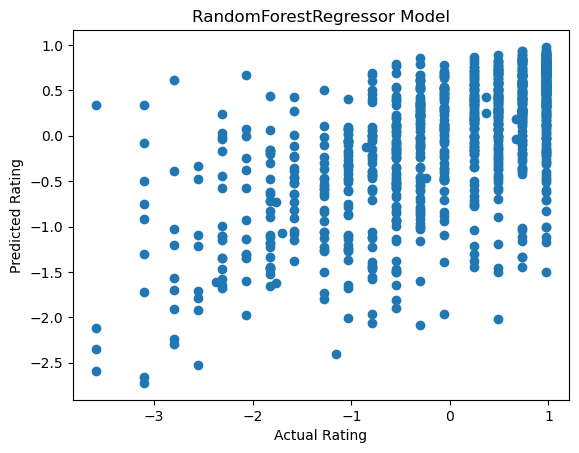

--------------------------------------------------
MSE : 0.546884 
XGBRegressor Model: test accuracy: 47.07%
--------------------------------------------------


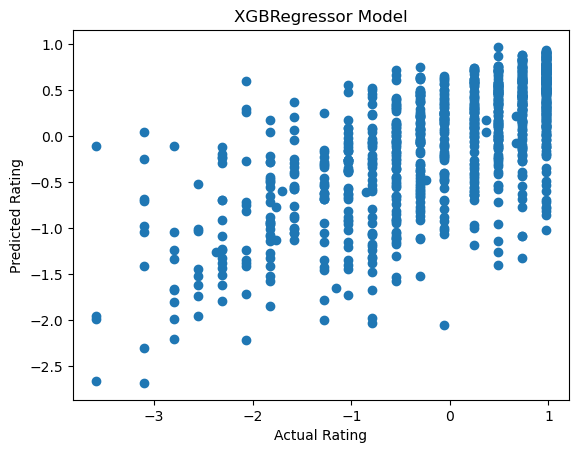

--------------------------------------------------
MSE : 0.547650 
LGBMRegressor Model: test accuracy: 47.00%
--------------------------------------------------


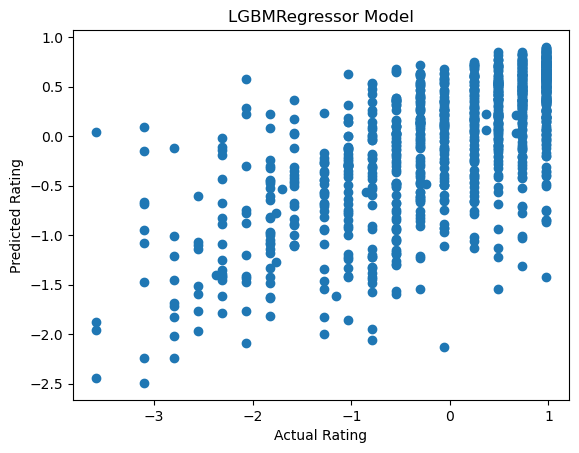

In [18]:
# Load the models
loaded_lr = load_model('Linear_Regression.pkl')
load_lasso = load_model('Lasso.pkl')

#loaded_poly= load_model('Polynomial.pkl')
#load_poly_features= load_model('poly_features.pkl')
#X_test_poly= load_poly_features.transform(X_test)

loaded_ridge = load_model('ridge.pkl')
#loaded_dt = load_model('DecisionTreeRegressor_model.pkl')
load_rf = load_model('RandomForestRegressor.pkl')
loaded_xgb= load_model('XGBRegressor.pkl')
loaded_kn = load_model('KNeighborsRegressor.pkl')
loaded_lgb = load_model('LGBMRegressor.pkl')
load_er = load_model('ElasticNet_regressor.pkl')
loaded_adb= load_model('adaboost_regressor.pkl')
loaded_qr = load_model('quantile_reg.pkl')
loaded_br = load_model('Bayesian_regressor.pkl')


# Calculate accuracy on test data && Confusion_Matrix

#predictions_test=Print_Accuracy(loaded_lr,X_test,y_test,data_name="test",model_name="Linear_Regression Model")
#Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "Linear_Regression Model")

#predictions_test=Print_Accuracy(load_lasso,X_test,y_test,data_name="test",model_name="Lasso Model")
#Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "Lasso Model")

#predictions_test=Print_Accuracy(loaded_poly,X_test_poly,y_test,data_name="test",model_name="Polynomial Model")
#Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "Polynomial Model")

#predictions_test=Print_Accuracy(loaded_ridge,X_test,y_test,data_name="test")
#Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "ridge Model")

#predictions_test=Print_Accuracy(loaded_dt,X_test,y_test,data_name="test")
#Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "DecisionTreeRegressor Model")

predictions_test=Print_Accuracy(load_rf,X_test,y_test,data_name="test",model_name="RandomForestRegressor Model")
Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "RandomForestRegressor Model")

predictions_test=Print_Accuracy(loaded_xgb,X_test,y_test,data_name="test",model_name="XGBRegressor Model")
Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "XGBRegressor Model")

#predictions_test=Print_Accuracy(loaded_kn,X_test,y_test,data_name="test")
#Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "KNeighborsRegressor Model")

predictions_test=Print_Accuracy(loaded_lgb,X_test,y_test,data_name="test",model_name="LGBMRegressor Model")
Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "LGBMRegressor Model")

#predictions_test=Print_Accuracy(load_er,X_test,y_test,data_name="test",model_name="ElasticNet_regressor Model")
#Display_Confusion_Matrix(y_data= y_test, predictions_data= predictions_test ,model_name= "ElasticNet_regressor Model")


